In [48]:
# pip install pygeoip
# pip install fastparquet 
# pip install dnspython
import pandas as pd
import numpy as np
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip
import matplotlib.pyplot as plt 

# datafile='./dataset9/test9.parquet'
datafile='./dataset9/data9.parquet'
data=pd.read_parquet(datafile)

gi=pygeoip.GeoIP('./GeoIP_DBs/GeoIP.dat')
gi2=pygeoip.GeoIP('./GeoIP_DBs/GeoIPASNum.dat')

In [49]:
#  functions
# Define a function to convert timestamps to a readable format
def convert_timestamp(timestamp):
    seconds = timestamp / 100
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"
    
# Function to get country code and organization
def get_geolocation_info(ip):
    try:
        cc = gi.country_code_by_addr(ip)
    except:
        cc = None
    try:
        org = gi2.org_by_addr(ip)
    except:
        org = None
    return cc, org

In [52]:
### IP geolocalization
# Check if the IP address is in the dataset
addr='192.168.109.59'

ip_present = addr in data['src_ip'].values or addr in data['dst_ip'].values

if ip_present:
    # Initialize GeoIP databases
    gi = pygeoip.GeoIP('./GeoIP_DBs/GeoIP.dat')
    gi2 = pygeoip.GeoIP('./GeoIP_DBs/GeoIPASNum.dat')

    # Perform geolocation lookup
    cc = gi.country_code_by_addr(addr)
    org = gi2.org_by_addr(addr)

    print("cc: ", cc, "org: ", org)
else:
    print(f"The IP address {addr} is not present in the dataset.")


cc:   org:  None


In [47]:

# Apply the function to each destination IP address
data[['dst_cc', 'dst_org']] = data['dst_ip'].apply(lambda ip: pd.Series(get_geolocation_info(ip)))

# Now you can see the added columns
print(data)

        timestamp          src_ip           dst_ip proto  port  up_bytes  \
index                                                                      
398780    1750958  192.168.109.93  192.168.109.227   tcp   443      6014   
398774    1750962  192.168.109.93  192.168.109.225   udp    53       215   
398775    1750967  192.168.109.93  192.168.109.225   udp    53       217   
398776    1750972  192.168.109.93  192.168.109.225   udp    53       231   
398781    1750973  192.168.109.93  192.168.109.227   tcp   443     19343   
...           ...             ...              ...   ...   ...       ...   
525483    8478512  192.168.109.47  142.250.184.174   tcp   443     16813   
525484    8478724  192.168.109.47  142.250.184.174   tcp   443     24723   
525485    8478863  192.168.109.47  142.250.184.174   tcp   443     11391   
525486    8478886  192.168.109.47  142.250.184.174   tcp   443     12767   
525487    8478980  192.168.109.47  142.250.184.174   tcp   443     13711   

        dow

In [22]:
# time stamps
import pandas as pd

# Assuming `data` is your DataFrame and 'timestamp' is in centiseconds
data['timestamp_seconds'] = data['timestamp'] / 100

# Convert 'timestamp_seconds' to datetime format assuming the data is for a single day
data['time'] = pd.to_datetime(data['timestamp_seconds'], unit='s', origin=pd.Timestamp('00:00:00'))

# Extract the hour from the 'time' column
data['hour'] = data['time'].dt.hour

# Filter the data for normal working hours (e.g., 9 AM to 5 PM)
working_hours_data = data[(data['hour'] >= 9) & (data['hour'] < 17)]

# Group by 'timestamp' and sum 'up_bytes' for the filtered data
hist_data = working_hours_data.groupby(['timestamp'])['up_bytes'].sum()

# Display the last 600 rows of the result
print(hist_data[-600:].to_string())

# Find the minimum timestamp
min_timestamp = data['timestamp'].min()

# Find the maximum timestamp
max_timestamp = data['timestamp'].max()

min_time_str = convert_timestamp(min_timestamp)
max_time_str = convert_timestamp(max_timestamp)


print("Minimum timestamp corresponds to:", min_time_str)
print("Maximum timestamp corresponds to:", max_time_str)


timestamp
6116145     4838
6116157     7431
6116173    14506
6116175     7029
6116179     4949
6116182    13506
6116185     7043
6116193     3401
6116199     8582
6116204     6725
6116210     7585
6116222     5058
6116241     6557
6116248     4603
6116258    15823
6116259     7212
6116260    15241
6116261    19151
6116262    13053
6116270      192
6116274      204
6116275      180
6116279    18018
6116281      186
6116283      179
6116284    12010
6116285     8254
6116286    10374
6116288      176
6116289    68221
6116293     8015
6116322    13540
6116335    10840
6116338     9689
6116344      167
6116347     8072
6116355    21087
6116357     5890
6116373    16125
6116377    15662
6116390     8530
6116397    18857
6116422     7179
6116429     2969
6116432    27149
6116447    25707
6116449     4659
6116454    11486
6116460     8473
6116467     3978
6116472    10213
6116473    13086
6116474    12905
6116476     4461
6116483    12353
6116495    12299
6116500    16688
6116510    26159
6116

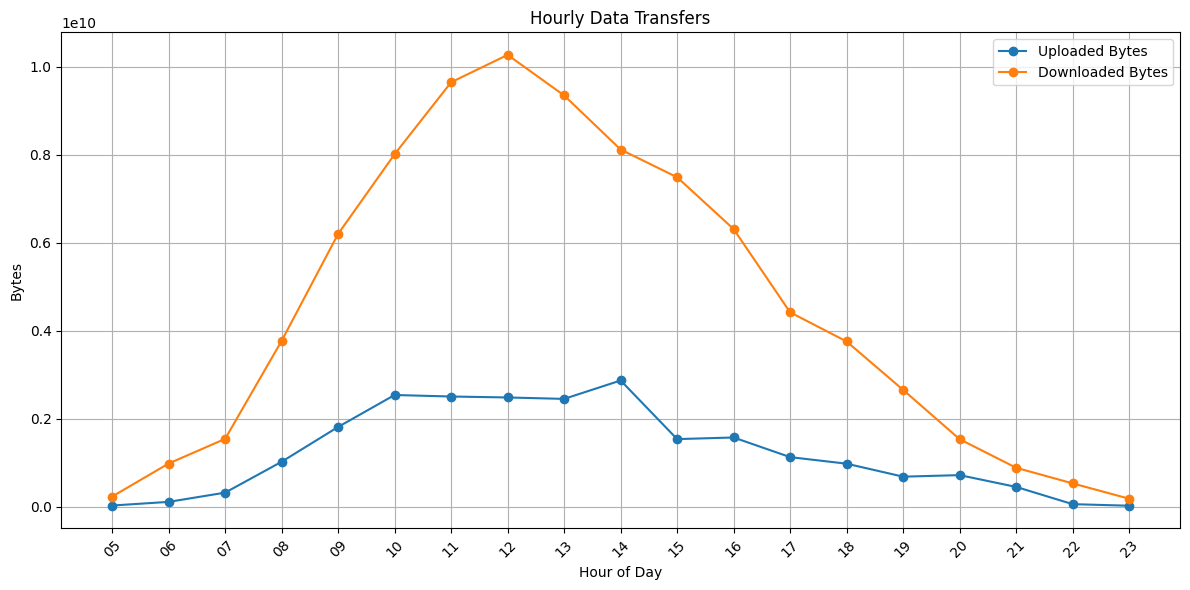

Peak upload hour: 14
Peak download hour: 12


In [23]:
# Max downloads in Working hours

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and 'timestamp' is in 1/100 of seconds from 0h of the day
data['timestamp'] = pd.to_datetime(data['timestamp'] / 100, unit='s').dt.strftime('%H')

# Group by hour and sum up the uploaded and downloaded bytes
hourly_data = data.groupby('timestamp').agg({'up_bytes': 'sum', 'down_bytes': 'sum'})

# Plot the hourly data transfers
plt.figure(figsize=(12, 6))
plt.plot(hourly_data.index, hourly_data['up_bytes'], label='Uploaded Bytes', marker='o')
plt.plot(hourly_data.index, hourly_data['down_bytes'], label='Downloaded Bytes', marker='o')
plt.title('Hourly Data Transfers')
plt.xlabel('Hour of Day')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Find the hour with the maximum data transfer
max_up_hour = hourly_data['up_bytes'].idxmax()
max_down_hour = hourly_data['down_bytes'].idxmax()
print(f"Peak upload hour: {max_up_hour}")
print(f"Peak download hour: {max_down_hour}")


In [41]:
#  random code 
import pandas as pd

# Load the data
data = pd.read_parquet('./dataset9/data9.parquet')
test_data = pd.read_parquet('./dataset9/test9.parquet')
servers_data = pd.read_parquet('./dataset9/servers9.parquet')

# Analyze typical behavior
typical_behavior = data.groupby(['src_ip', 'dst_ip', 'proto', 'port']).agg({'up_bytes': 'sum', 'down_bytes': 'sum'}).reset_index()

# Identify internal servers/services
internal_servers = typical_behavior[typical_behavior['dst_ip'].str.startswith('192.168.')]

# Describe and quantify traffic exchanges
traffic_summary = internal_servers.groupby(['src_ip', 'dst_ip']).agg({'up_bytes': 'sum', 'down_bytes': 'sum'}).reset_index()

# Define SIEM rules
def detect_botnet_activities(df):
    # Example rule: high-frequency low-volume connections
    suspicious = df[(df['proto'] == 'tcp') & (df['up_bytes'] < 1000) & (df['down_bytes'] < 1000)]
    return suspicious

def detect_data_exfiltration(df):
    # Example rule: large volume of HTTPS traffic
    suspicious = df[(df['proto'] == 'tcp') & (df['port'] == 443) & (df['up_bytes'] > 1000000)]
    return suspicious

def detect_cnc_activities(df):
    # Example rule: high-frequency DNS queries
    suspicious = df[(df['proto'] == 'udp') & (df['port'] == 53) & (df['up_bytes'] < 500)]
    return suspicious

def detect_anomalous_external_users(df):
    # Example rule: unusual access patterns to public servers
    suspicious = df[(df['dst_ip'].str.startswith('200.0.0.')) & (df['up_bytes'] > 1000000)]
    return suspicious

# Apply SIEM rules to test data
botnet_activities = detect_botnet_activities(test_data)
data_exfiltration = detect_data_exfiltration(test_data)
cnc_activities = detect_cnc_activities(test_data)
anomalous_external_users = detect_anomalous_external_users(servers_data)

# Combine results and identify anomalous devices
anomalous_devices = pd.concat([botnet_activities, data_exfiltration, cnc_activities, anomalous_external_users]).drop_duplicates()

# Print the results
print("Anomalous devices detected:")
print(anomalous_devices)

# Save results to a file for the report
anomalous_devices.to_csv('anomalous_devices_report.csv', index=False)


Anomalous devices detected:
        timestamp           src_ip           dst_ip proto  port  up_bytes  \
index                                                                       
918961    3132759   192.168.109.14   192.168.109.31   tcp   443       994   
918972    3223140   192.168.109.14  192.168.109.126   tcp   443       774   
919323    3238769  192.168.109.168  192.168.109.126   tcp   443       584   
919336    3419175  192.168.109.168  192.168.109.126   tcp   443       922   
919014    3585016   192.168.109.14   192.168.109.61   tcp   443       577   
...           ...              ...              ...   ...   ...       ...   
361994    8475823   192.168.109.62  192.168.109.230   udp    53       218   
822236    8479311   192.168.109.35  192.168.109.230   udp    53       239   
822237    8479317   192.168.109.35  192.168.109.230   udp    53       214   
822238    8479321   192.168.109.35  192.168.109.230   udp    53       248   
243110    8485881  192.168.109.133  192.168.109.

Potential DNS servers based on traffic to port 53:
            dst_ip  count
1  192.168.109.230  72241
0  192.168.109.225  70679
Protocol usage for DNS traffic (port 53):
proto
udp    142920
Name: count, dtype: int64


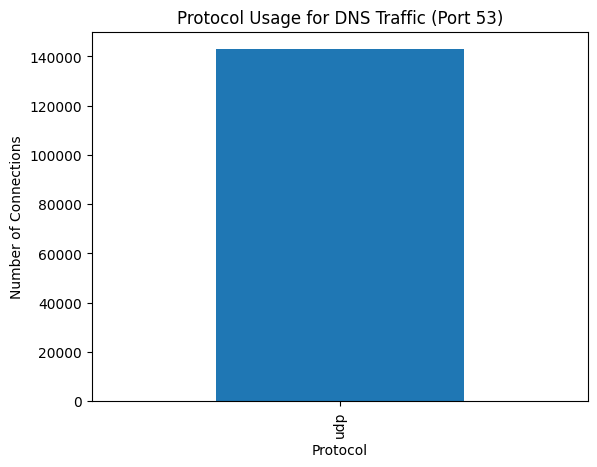

In [24]:
# DNS servers?

import pandas as pd

# Assuming 'data' is your DataFrame with columns: ['timestamp', 'src_ip', 'dst_ip', 'proto', 'port', 'up_bytes', 'down_bytes']

# Filter for DNS traffic (port 53 with UDP or TCP)
dns_traffic = data[(data['port'] == 53) & ((data['proto'] == 'udp') | (data['proto'] == 'tcp'))]

# Group by destination IP to identify potential DNS servers
dns_servers = dns_traffic.groupby('dst_ip').size().reset_index(name='count').sort_values(by='count', ascending=False)

# Print the identified DNS servers and the number of connections
print("Potential DNS servers based on traffic to port 53:")
print(dns_servers)

# Additional analysis: Check which protocol is used more frequently for DNS traffic
protocol_usage = dns_traffic['proto'].value_counts()
print("Protocol usage for DNS traffic (port 53):")
print(protocol_usage)

# Plot the protocol usage for DNS traffic
protocol_usage.plot(kind='bar', title='Protocol Usage for DNS Traffic (Port 53)', xlabel='Protocol', ylabel='Number of Connections')
plt.show()


/var/folders/jd/jty1v4yj6917gdbjznt2_r_h0000gn/T/ipykernel_38782/1250672808.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dns_traffic['total_bytes'] = dns_traffic['up_bytes'] + dns_traffic['down_bytes']


Summary statistics for DNS traffic (port 53):
            up_bytes     down_bytes    total_bytes
count  142920.000000  142920.000000  142920.000000
mean      199.887497     459.345613     659.233109
std        32.607613     118.674829     143.177527
min        80.000000      93.000000     174.000000
25%       177.000000     375.000000     559.000000
50%       199.000000     450.000000     650.000000
75%       221.000000     534.000000     750.000000
max       390.000000    1131.000000    1421.000000


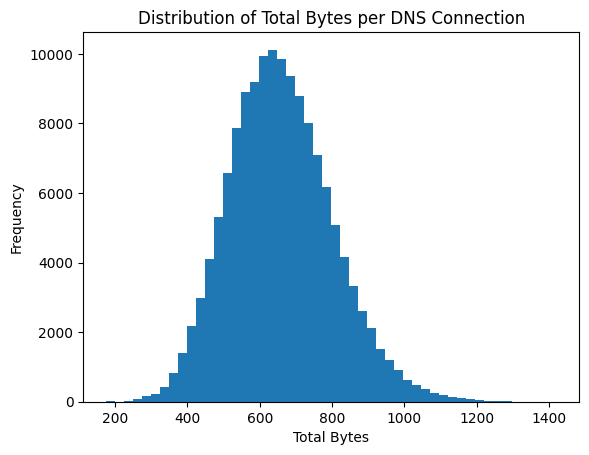

In [25]:
# connections size for the DNS server
import pandas as pd

# Assuming 'data' is your DataFrame with columns: ['timestamp', 'src_ip', 'dst_ip', 'proto', 'port', 'up_bytes', 'down_bytes']

# Filter for DNS traffic (port 53)
dns_traffic = data[(data['port'] == 53)]

# Calculate the sizes of connections to the DNS server
dns_traffic['total_bytes'] = dns_traffic['up_bytes'] + dns_traffic['down_bytes']

# Summarize the data
dns_summary = dns_traffic[['up_bytes', 'down_bytes', 'total_bytes']].describe()

# Print the summary statistics
print("Summary statistics for DNS traffic (port 53):")
print(dns_summary)

# Plot the distribution of total bytes per connection to DNS server
dns_traffic['total_bytes'].plot(kind='hist', bins=50, title='Distribution of Total Bytes per DNS Connection', xlabel='Total Bytes', ylabel='Frequency')
plt.show()


In [40]:
import pandas as pd

# Load the serversX.parquet file
servers_data = pd.read_parquet('./dataset9/data9.parquet')

# Display the first few rows of the data
print("First few rows of the data:")
print(servers_data.head())

# Define the corporation server IP range
corp_server_ip_range = '200.0.0.'

# Filter the data for external access to the corporation servers
external_access = servers_data[servers_data['dst_ip'].str.startswith(corp_server_ip_range)]

# Display the first few rows of the filtered data
print("\nFiltered data (external access to corporation servers):")
print(external_access.head())

# Group by source IP and destination IP to see access patterns
access_patterns = external_access.groupby(['src_ip', 'dst_ip']).size().reset_index(name='access_count')

# Display the access patterns
print("\nAccess patterns (number of connections to each machine):")
print(access_patterns)

# Alternatively, get the number of connections to each destination machine
connections_to_each_machine = external_access['dst_ip'].value_counts().reset_index()
connections_to_each_machine.columns = ['dst_ip', 'connection_count']

print("\nNumber of connections to each machine (destination IP):")
print(connections_to_each_machine)

# If you want to save this to a CSV for further analysis
connections_to_each_machine.to_csv('/mnt/data/connections_to_each_machine.csv', index=False)

# Visualize the number of connections to each destination IP
import matplotlib.pyplot as plt

connections_to_each_machine.set_index('dst_ip')['connection_count'].plot(kind='bar', figsize=(12, 6))
plt.title('Number of Connections to Each Destination IP')
plt.xlabel('Destination IP')
plt.ylabel('Number of Connections')
plt.show()


First few rows of the data:
        timestamp          src_ip           dst_ip proto  port  up_bytes  \
index                                                                      
398780    1750958  192.168.109.93  192.168.109.227   tcp   443      6014   
398774    1750962  192.168.109.93  192.168.109.225   udp    53       215   
398775    1750967  192.168.109.93  192.168.109.225   udp    53       217   
398776    1750972  192.168.109.93  192.168.109.225   udp    53       231   
398781    1750973  192.168.109.93  192.168.109.227   tcp   443     19343   

        down_bytes  
index               
398780       61979  
398774         624  
398775         619  
398776         623  
398781     1742036  

Filtered data (external access to corporation servers):
Empty DataFrame
Columns: [timestamp, src_ip, dst_ip, proto, port, up_bytes, down_bytes]
Index: []

Access patterns (number of connections to each machine):
Empty DataFrame
Columns: [src_ip, dst_ip, access_count]
Index: []

Number of co

OSError: Cannot save file into a non-existent directory: '/mnt/data'

In [26]:
import pandas as pd

# Assuming 'data' is your DataFrame with a 'dst_cc' column for country codes
# If 'dst_cc' column is not available yet, you need to geolocate IP addresses to get the country codes

# Extract the unique country codes
unique_countries = data['dst_cc'].unique()

# Count the number of unique country codes
num_unique_countries = len(unique_countries)

# Print the result
print(f"Number of unique countries accessed: {num_unique_countries}")
print(f"Countries accessed: {unique_countries}")


Number of unique countries accessed: 60
Countries accessed: ['US' '' 'PT' 'NL' 'DE' 'GB' 'ES' 'NA' 'IT' 'BR' 'FR' 'IE' 'JP' 'CN' 'HK'
 'RU' 'SG' 'LB' 'CA' 'LU' 'AE' 'CZ' 'BE' 'BD' 'IN' 'CH' 'ZA' 'MM' 'UA'
 'KZ' 'SA' 'SE' 'AU' 'SI' 'ID' 'KG' 'KR' 'IR' 'HR' 'LV' 'BH' 'NO' 'IL'
 'PG' 'DK' 'AM' 'TW' 'GL' 'PL' 'UZ' 'MX' 'RO' 'NZ' 'IQ' 'EE' 'BZ' 'SC'
 'MY' 'VN' 'CL']


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to process chunks
def process_chunk(chunk):
    chunk['timestamp'] = pd.to_datetime(chunk['timestamp'], unit='s')
    return chunk

# Read and process the data in chunks
chunks = pd.read_parquet('./dataset9/test9.parquet', chunksize=100000)

# Initialize an empty DataFrame to hold processed data
processed_data = pd.DataFrame()

for chunk in chunks:
    processed_chunk = process_chunk(chunk)
    processed_data = pd.concat([processed_data, processed_chunk])

# Set 'timestamp' as the index for easier resampling
processed_data.set_index('timestamp', inplace=True)

# Resample the data to hourly intervals and sum up the 'up_bytes'
hourly_data = processed_data['up_bytes'].resample('H').sum()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(hourly_data)
plt.title('Hourly Upload Activity')
plt.xlabel('Time')
plt.ylabel('Uploaded Bytes')
plt.show()

# For checking periodicity using a Fourier transform (optional)
import numpy as np

# Compute the Fourier transform
fft = np.fft.fft(hourly_data)
frequencies = np.fft.fftfreq(len(fft))

# Plot the Fourier transform
plt.figure(figsize=(12, 6))
plt.plot(frequencies, np.abs(fft))
plt.title('Fourier Transform of Upload Activity')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()


TypeError: read_table() got an unexpected keyword argument 'chunksize'